In [1]:
!pip install 'zarr<3'
!pip install timm


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Specify GPU 0 (out of 4 available GPUs)
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))
print(f"✅ Working directory: {os.getcwd()}")
print(f"✅ Using GPU: {os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set')}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest
✅ Using GPU: 2


## Data Loading

In [2]:
# Cell 3: Import and create dataloaders
from dataset import Config, create_dataloaders

# Just use the correct relative path from your working directory
config = Config("configs/training/config_fold3.yaml")  # Note: "configs" not "config"
config.print_config()

train_loader, val_loader, test_loader = create_dataloaders(config)
print("\n✅ Ready to use!")

✅ CRC Dataset Package v1.0.0 loaded
CRC DATASET CONFIGURATION
Config File: configs/training/config_fold3.yaml
Zarr Base: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/ORION-CRC/zarr_data
Cache: ./cache/multimodal_dataset_cache_fold3.pkl
Strategy: memory

📊 Data Splits:
  Train: 33 samples
  Val: 9 samples
  Test: 8 samples

🔄 DataLoader:
  Batch Size: 4
  Num Workers: 0
  Pin Memory: True

🎨 Augmentation:
  Training: True
  Probability: 0.0

🎯 HV Maps:
  Generate: True
  Method: pannuke
  HE Nuclei: True
  HE Cells: True
  MIF Nuclei: True
  MIF Cells: True

🔍 Filtering:
  Min Instances: 0
  Filter Empty: True

CREATING DATALOADERS
Strategy: memory
Use Cache: True
Batch Size: 4
Num Workers: 0

Train split: 27 CRC + 6 Xenium samples
Val split: 7 CRC + 2 Xenium samples
Test split: 7 CRC + 1 Xenium samples

📦 Loading from cache: ./cache/combined_cache_train_0be9581c.pkl
📦 Loaded 3294 patches from cache
📦 Loading from cache: ./cache/combined_cache_val_0ed6113d.pkl
📦 Loaded 1444 

## Flex Metrics

Using device: cuda

📦 Loading model...
✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
✅ Model loaded

🔍 EXPLORING TEST DATASET BY CASE

Total samples: 508
Total cases: 8

📋 Available cases and patch counts:
  CRC15: 18 patches
  CRC16: 142 patches
  CRC17: 76 patches
  CRC18: 80 patches
  CRC19: 29 patches
  CRC20: 35 patches
  CRC39: 62 patches
  lung: 66 patches


🎯 Selecting random sample from case: lung
   ✅ Found case with 66 patches
   ✅ Selected patch index: 490 (patch 48)

📍 Processing: N/A
🔄 Running inference...

📊 BINARY SEGMENTATION METRICS

🔬 NUCLEI:
  Dice:      0.9367
  IoU:       0.8810
  Precision: 0.9761
  Recall:    0.9004
  F1 Score:  0.9367

🧬 CELL:
  Dice:      0.9159
  IoU:       0.8448
  Precision: 0.8830
  Recall:    0.9513
  F1 Score:  0.9159

🔬 INSTANCE SEGMENTATION POST-PROCESSING
Nuclei HV magnitude range: [0.000, 1.208]
Cell HV magnitude range: [0.00

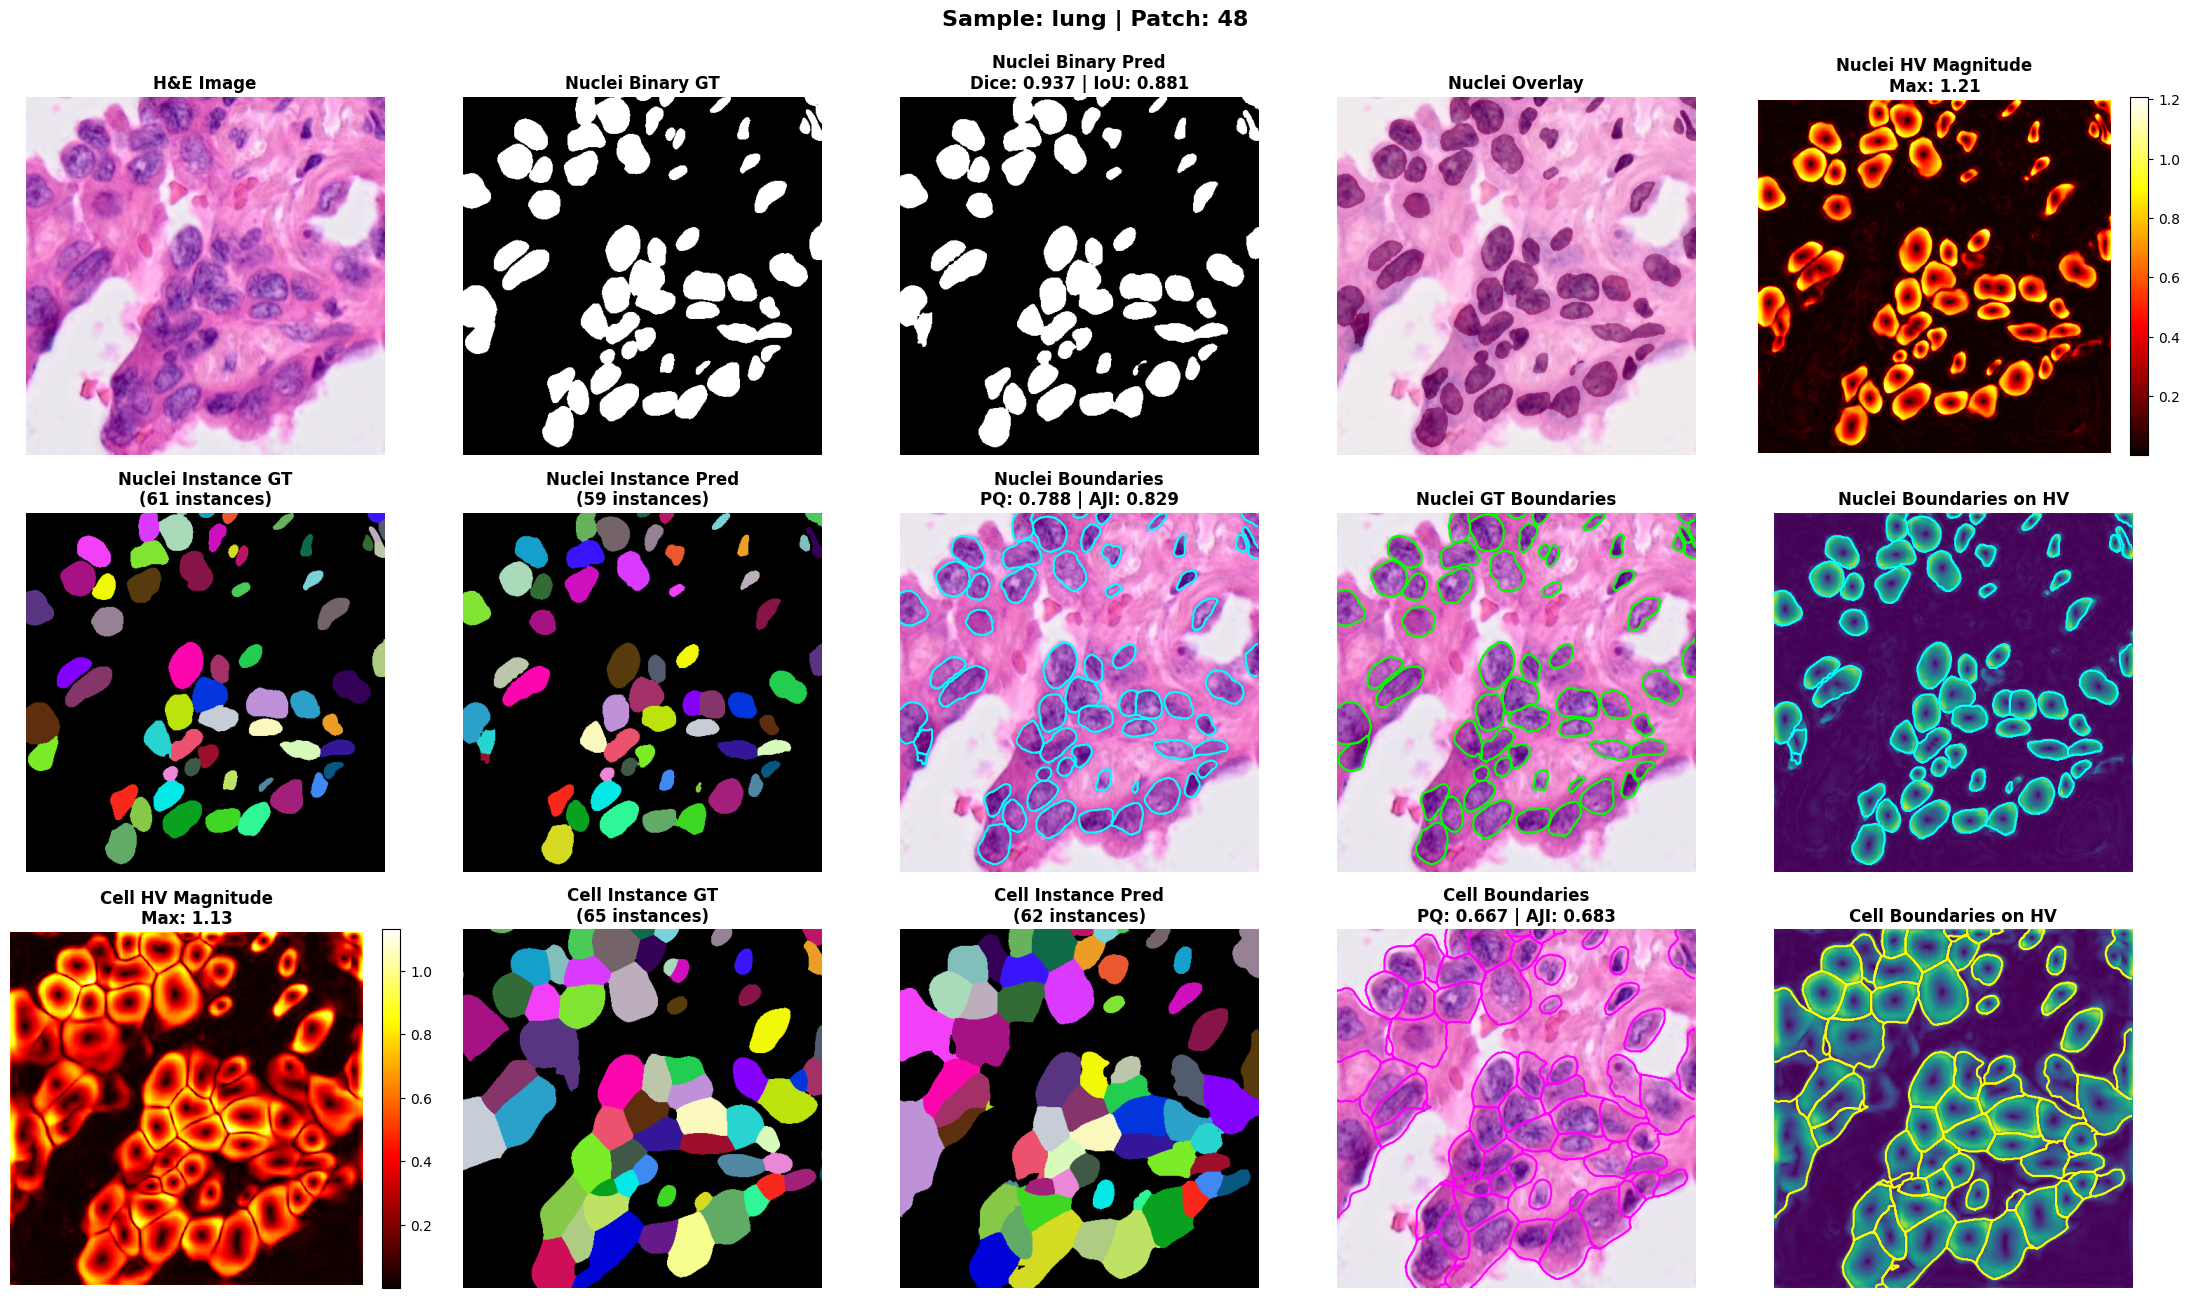


✅ Complete evaluation finished!

💡 Visualization shows:
   Row 1: Binary nuclei segmentation + HV magnitude
   Row 2: Nuclei instance segmentation with boundaries (on image & HV map)
   Row 3: Cell HV magnitude + Cell instance segmentation with boundaries


In [21]:
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import random

# Import all metrics
from metrics import (
    dice_coefficient, 
    iou_score, 
    precision_score, 
    recall_score,
    f1_score,
    panoptic_quality,
    aggregated_jaccard_index
)
from vitaminp import VitaminPFlex, SimplePreprocessing, prepare_he_input
from postprocessing import process_model_outputs

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model
print("\n📦 Loading model...")
model = VitaminPFlex(model_size='large').to(device)
checkpoint_path = "checkpoints/vitamin_p_flex_large_fold3_best.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"✅ Model loaded")

# Preprocessor
preprocessor = SimplePreprocessing()

# ========== EXPLORE TEST DATASET BY CASE ==========
print("\n" + "="*70)
print("🔍 EXPLORING TEST DATASET BY CASE")
print("="*70)

# Build index of samples by case name
case_index = {}
for idx in range(len(test_loader.dataset)):
    sample = test_loader.dataset[idx]
    case_name = sample['sample_name']
    
    if case_name not in case_index:
        case_index[case_name] = []
    case_index[case_name].append(idx)

# Print all available cases
print(f"\nTotal samples: {len(test_loader.dataset)}")
print(f"Total cases: {len(case_index)}")
print("\n📋 Available cases and patch counts:")
for case_name in sorted(case_index.keys()):
    print(f"  {case_name}: {len(case_index[case_name])} patches")

print("\n" + "="*70)

# ========== SELECT SAMPLE FROM SPECIFIC CASE ==========
# 🎯 CHANGE THIS TO SELECT YOUR DESIRED CASE
SELECTED_CASE = "lung"  # <-- MODIFY THIS TO CHOOSE DIFFERENT CASE

print(f"\n🎯 Selecting random sample from case: {SELECTED_CASE}")

if SELECTED_CASE in case_index:
    available_indices = case_index[SELECTED_CASE]
    random_idx = random.choice(available_indices)
    batch = test_loader.dataset[random_idx]
    print(f"   ✅ Found case with {len(available_indices)} patches")
    print(f"   ✅ Selected patch index: {random_idx} (patch {batch['patch_idx']})")
else:
    print(f"   ⚠️ Case '{SELECTED_CASE}' not found!")
    print(f"   Available cases: {sorted(case_index.keys())[:10]}...")
    # Fallback to random selection
    random_idx = random.randint(0, len(test_loader.dataset) - 1)
    batch = test_loader.dataset[random_idx]
    print(f"   Using random sample: {batch['sample_name']} patch {batch['patch_idx']}")

# Add batch dimension (since dataset returns single sample)
for key in batch.keys():
    if isinstance(batch[key], torch.Tensor):
        batch[key] = batch[key].unsqueeze(0)

print(f"\n📍 Processing: {batch['sample_name'][0] if isinstance(batch['sample_name'], list) else 'N/A'}")

# Prepare H&E input
he_img = prepare_he_input(batch['he_image'].to(device))
he_img = preprocessor.percentile_normalize(he_img)

# Ground truth
nuclei_mask_gt = batch['he_nuclei_mask'].float().unsqueeze(1).to(device)
cell_mask_gt = batch['he_cell_mask'].float().unsqueeze(1).to(device)
nuclei_inst_gt = batch['he_nuclei_instance'][0].cpu().numpy()  # Instance map
cell_inst_gt = batch['he_cell_instance'][0].cpu().numpy()  # Instance map

# Inference
print("🔄 Running inference...")
with torch.no_grad():
    outputs = model(he_img)

# Get predictions
pred_nuclei = (outputs['he_nuclei_seg'] > 0.5).float()
pred_cell = (outputs['he_cell_seg'] > 0.5).float()

# ========== BINARY SEGMENTATION METRICS ==========
print("\n" + "="*70)
print("📊 BINARY SEGMENTATION METRICS")
print("="*70)

# Nuclei metrics
nuclei_dice = dice_coefficient(pred_nuclei, nuclei_mask_gt)
nuclei_iou = iou_score(pred_nuclei, nuclei_mask_gt)
nuclei_precision = precision_score(pred_nuclei, nuclei_mask_gt)
nuclei_recall = recall_score(pred_nuclei, nuclei_mask_gt)
nuclei_f1 = f1_score(pred_nuclei, nuclei_mask_gt)

print("\n🔬 NUCLEI:")
print(f"  Dice:      {nuclei_dice:.4f}")
print(f"  IoU:       {nuclei_iou:.4f}")
print(f"  Precision: {nuclei_precision:.4f}")
print(f"  Recall:    {nuclei_recall:.4f}")
print(f"  F1 Score:  {nuclei_f1:.4f}")

# Cell metrics
cell_dice = dice_coefficient(pred_cell, cell_mask_gt)
cell_iou = iou_score(pred_cell, cell_mask_gt)
cell_precision = precision_score(pred_cell, cell_mask_gt)
cell_recall = recall_score(pred_cell, cell_mask_gt)
cell_f1 = f1_score(pred_cell, cell_mask_gt)

print("\n🧬 CELL:")
print(f"  Dice:      {cell_dice:.4f}")
print(f"  IoU:       {cell_iou:.4f}")
print(f"  Precision: {cell_precision:.4f}")
print(f"  Recall:    {cell_recall:.4f}")
print(f"  F1 Score:  {cell_f1:.4f}")

# ========== INSTANCE SEGMENTATION ==========
print("\n" + "="*70)
print("🔬 INSTANCE SEGMENTATION POST-PROCESSING")
print("="*70)

# Extract predictions for post-processing (first sample, remove batch and channel dims)
nuclei_seg_np = outputs['he_nuclei_seg'][0, 0].cpu().numpy()
nuclei_h_map = outputs['he_nuclei_hv'][0, 0].cpu().numpy()
nuclei_v_map = outputs['he_nuclei_hv'][0, 1].cpu().numpy()

cell_seg_np = outputs['he_cell_seg'][0, 0].cpu().numpy()
cell_h_map = outputs['he_cell_hv'][0, 0].cpu().numpy()
cell_v_map = outputs['he_cell_hv'][0, 1].cpu().numpy()

# Compute HV magnitude
nuclei_hv_magnitude = np.sqrt(nuclei_h_map**2 + nuclei_v_map**2)
cell_hv_magnitude = np.sqrt(cell_h_map**2 + cell_v_map**2)

print(f"Nuclei HV magnitude range: [{nuclei_hv_magnitude.min():.3f}, {nuclei_hv_magnitude.max():.3f}]")
print(f"Cell HV magnitude range: [{cell_hv_magnitude.min():.3f}, {cell_hv_magnitude.max():.3f}]")

# Apply post-processing to get instance maps
print("Processing nuclei instances...")
nuclei_inst_pred, nuclei_info, num_nuclei = process_model_outputs(
    nuclei_seg_np, nuclei_h_map, nuclei_v_map,
    magnification=40
)

print("Processing cell instances...")
cell_inst_pred, cell_info, num_cells = process_model_outputs(
    cell_seg_np, cell_h_map, cell_v_map,
    magnification=40
)

print(f"\n✅ Detected {num_nuclei} nuclei instances")
print(f"✅ Detected {num_cells} cell instances")

# ========== INSTANCE METRICS ==========
print("\n" + "="*70)
print("📊 INSTANCE SEGMENTATION METRICS")
print("="*70)

# Nuclei instance metrics
nuclei_pq = panoptic_quality(nuclei_inst_gt, nuclei_inst_pred)
nuclei_aji = aggregated_jaccard_index(nuclei_inst_gt, nuclei_inst_pred)

print("\n🔬 NUCLEI INSTANCES:")
print(f"  PQ (Panoptic Quality): {nuclei_pq:.4f}")
print(f"  AJI (Agg. Jaccard):    {nuclei_aji:.4f}")
print(f"  Count GT:              {len(np.unique(nuclei_inst_gt)) - 1}")
print(f"  Count Pred:            {num_nuclei}")

# Cell instance metrics
cell_pq = panoptic_quality(cell_inst_gt, cell_inst_pred)
cell_aji = aggregated_jaccard_index(cell_inst_gt, cell_inst_pred)

print("\n🧬 CELL INSTANCES:")
print(f"  PQ (Panoptic Quality): {cell_pq:.4f}")
print(f"  AJI (Agg. Jaccard):    {cell_aji:.4f}")
print(f"  Count GT:              {len(np.unique(cell_inst_gt)) - 1}")
print(f"  Count Pred:            {num_cells}")

print("\n" + "="*70)

# ========== VISUALIZATION WITH HV MAPS AND BOUNDARIES ==========
print("\n🎨 Creating visualization with instance boundaries...")

fig, axes = plt.subplots(3, 5, figsize=(22, 13))

# Get original image for visualization
he_vis = batch['he_image'][0].permute(1, 2, 0).cpu().numpy()

# Convert masks to numpy
nuclei_gt_vis = nuclei_mask_gt[0, 0].cpu().numpy()
cell_gt_vis = cell_mask_gt[0, 0].cpu().numpy()
nuclei_pred_vis = pred_nuclei[0, 0].cpu().numpy()
cell_pred_vis = pred_cell[0, 0].cpu().numpy()

# Helper function to create colored instance map
def colorize_instance_map(instance_map):
    """Convert instance map to RGB with random colors per instance"""
    colored = np.zeros((*instance_map.shape, 3), dtype=np.uint8)
    instance_ids = np.unique(instance_map)
    instance_ids = instance_ids[instance_ids != 0]  # Remove background
    
    np.random.seed(42)  # For reproducibility
    for inst_id in instance_ids:
        color = np.random.randint(0, 255, 3)
        colored[instance_map == inst_id] = color
    
    return colored

# Helper function to draw instance boundaries
def draw_instance_boundaries(ax, img, instance_map, color='red', linewidth=1.5):
    """Draw boundaries of instances on image"""
    ax.imshow(img)
    
    # Get unique instance IDs
    inst_ids = np.unique(instance_map)
    inst_ids = inst_ids[inst_ids != 0]  # Exclude background
    
    # Draw contours for each instance
    from skimage import measure
    for inst_id in inst_ids:
        mask = (instance_map == inst_id).astype(np.uint8)
        contours = measure.find_contours(mask, 0.5)
        
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)

# Add title with case info
sample_name = batch['sample_name'][0] if isinstance(batch['sample_name'], list) else str(batch['sample_name'])
patch_idx = batch['patch_idx'][0].item() if isinstance(batch['patch_idx'], torch.Tensor) else batch['patch_idx']
fig.suptitle(f'Sample: {sample_name} | Patch: {patch_idx}', fontsize=16, fontweight='bold', y=0.995)

# Row 1: Nuclei Binary Segmentation + HV magnitude
axes[0, 0].imshow(he_vis)
axes[0, 0].set_title('H&E Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(nuclei_gt_vis, cmap='gray')
axes[0, 1].set_title('Nuclei Binary GT', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(nuclei_pred_vis, cmap='gray')
axes[0, 2].set_title(f'Nuclei Binary Pred\nDice: {nuclei_dice:.3f} | IoU: {nuclei_iou:.3f}', 
                     fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

axes[0, 3].imshow(he_vis)
axes[0, 3].imshow(nuclei_pred_vis, cmap='Reds', alpha=0.3)
axes[0, 3].set_title('Nuclei Overlay', fontsize=12, fontweight='bold')
axes[0, 3].axis('off')

im_nuclei_hv = axes[0, 4].imshow(nuclei_hv_magnitude, cmap='hot')
axes[0, 4].set_title(f'Nuclei HV Magnitude\nMax: {nuclei_hv_magnitude.max():.2f}', 
                     fontsize=12, fontweight='bold')
axes[0, 4].axis('off')
plt.colorbar(im_nuclei_hv, ax=axes[0, 4], fraction=0.046)

# Row 2: Nuclei Instance Segmentation
nuclei_inst_gt_colored = colorize_instance_map(nuclei_inst_gt)
axes[1, 0].imshow(nuclei_inst_gt_colored)
axes[1, 0].set_title(f'Nuclei Instance GT\n({len(np.unique(nuclei_inst_gt))-1} instances)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

nuclei_inst_pred_colored = colorize_instance_map(nuclei_inst_pred)
axes[1, 1].imshow(nuclei_inst_pred_colored)
axes[1, 1].set_title(f'Nuclei Instance Pred\n({num_nuclei} instances)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

draw_instance_boundaries(axes[1, 2], he_vis, nuclei_inst_pred, color='cyan', linewidth=1.5)
axes[1, 2].set_title(f'Nuclei Boundaries\nPQ: {nuclei_pq:.3f} | AJI: {nuclei_aji:.3f}', 
                     fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

draw_instance_boundaries(axes[1, 3], he_vis, nuclei_inst_gt, color='lime', linewidth=1.5)
axes[1, 3].set_title('Nuclei GT Boundaries', fontsize=12, fontweight='bold')
axes[1, 3].axis('off')

draw_instance_boundaries(axes[1, 4], nuclei_hv_magnitude, nuclei_inst_pred, color='cyan', linewidth=1.5)
axes[1, 4].set_title('Nuclei Boundaries on HV', fontsize=12, fontweight='bold')
axes[1, 4].axis('off')

# Row 3: Cell Instance Segmentation + HV magnitude
im_cell_hv = axes[2, 0].imshow(cell_hv_magnitude, cmap='hot')
axes[2, 0].set_title(f'Cell HV Magnitude\nMax: {cell_hv_magnitude.max():.2f}', 
                     fontsize=12, fontweight='bold')
axes[2, 0].axis('off')
plt.colorbar(im_cell_hv, ax=axes[2, 0], fraction=0.046)

cell_inst_gt_colored = colorize_instance_map(cell_inst_gt)
axes[2, 1].imshow(cell_inst_gt_colored)
axes[2, 1].set_title(f'Cell Instance GT\n({len(np.unique(cell_inst_gt))-1} instances)', 
                     fontsize=12, fontweight='bold')
axes[2, 1].axis('off')

cell_inst_pred_colored = colorize_instance_map(cell_inst_pred)
axes[2, 2].imshow(cell_inst_pred_colored)
axes[2, 2].set_title(f'Cell Instance Pred\n({num_cells} instances)', 
                     fontsize=12, fontweight='bold')
axes[2, 2].axis('off')

draw_instance_boundaries(axes[2, 3], he_vis, cell_inst_pred, color='magenta', linewidth=1.5)
axes[2, 3].set_title(f'Cell Boundaries\nPQ: {cell_pq:.3f} | AJI: {cell_aji:.3f}', 
                     fontsize=12, fontweight='bold')
axes[2, 3].axis('off')

draw_instance_boundaries(axes[2, 4], cell_hv_magnitude, cell_inst_pred, color='yellow', linewidth=1.5)
axes[2, 4].set_title('Cell Boundaries on HV', fontsize=12, fontweight='bold')
axes[2, 4].axis('off')

plt.tight_layout()
print(f"\n💾 Saved visualization: eval_{sample_name}_patch{patch_idx}.png")
plt.show()

print("\n✅ Complete evaluation finished!")
print("\n💡 Visualization shows:")
print("   Row 1: Binary nuclei segmentation + HV magnitude")
print("   Row 2: Nuclei instance segmentation with boundaries (on image & HV map)")
print("   Row 3: Cell HV magnitude + Cell instance segmentation with boundaries")

## All smaples

In [8]:
import torch
import numpy as np
from collections import defaultdict
from metrics import (
    dice_coefficient, 
    iou_score, 
    precision_score, 
    recall_score,
    f1_score
)
from vitaminp import VitaminPFlex, SimplePreprocessing, prepare_he_input, prepare_mif_input
from tqdm import tqdm

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model
print("\n📦 Loading model...")
model = VitaminPFlex(model_size='large').to(device)
checkpoint_path = "checkpoints/vitamin_p_flex_large_fold3_best.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"✅ Model loaded")

# Preprocessor
preprocessor = SimplePreprocessing()

# Initialize metric storage PER SAMPLE for BOTH H&E and MIF
sample_metrics = defaultdict(lambda: {
    'he_nuclei_dice': [], 'he_nuclei_iou': [], 
    'he_cell_dice': [], 'he_cell_iou': [],
    'mif_nuclei_dice': [], 'mif_nuclei_iou': [],
    'mif_cell_dice': [], 'mif_cell_iou': [],
    'patch_count': 0
})

print(f"\n🔄 Evaluating on all test samples (H&E + MIF - BINARY METRICS ONLY)...")

skipped_batches = 0

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Processing batches")):
        
        try:
            # ========== H&E PROCESSING ==========
            he_img = prepare_he_input(batch['he_image'].to(device))
            he_img = preprocessor.percentile_normalize(he_img)
            
            he_nuclei_mask_gt = batch['he_nuclei_mask'].float().unsqueeze(1).to(device)
            he_cell_mask_gt = batch['he_cell_mask'].float().unsqueeze(1).to(device)
            
            # ========== MIF PROCESSING ==========
            mif_img = prepare_mif_input(batch['mif_image'].to(device))
            mif_img = preprocessor.percentile_normalize(mif_img)
            
            mif_nuclei_mask_gt = batch['mif_nuclei_mask'].float().unsqueeze(1).to(device)
            mif_cell_mask_gt = batch['mif_cell_mask'].float().unsqueeze(1).to(device)
            
            # Get sample names
            sample_names = batch['sample_name']
            
            # ========== INFERENCE - H&E ==========
            outputs_he = model(he_img)  # Process H&E
            
            # ========== INFERENCE - MIF ==========
            outputs_mif = model(mif_img)  # Process MIF
            
            # Get predictions
            pred_he_nuclei = (outputs_he['he_nuclei_seg'] > 0.5).float()
            pred_he_cell = (outputs_he['he_cell_seg'] > 0.5).float()
            pred_mif_nuclei = (outputs_mif['mif_nuclei_seg'] > 0.5).float()
            pred_mif_cell = (outputs_mif['mif_cell_seg'] > 0.5).float()
            
            # Process each sample in the batch
            batch_size = pred_he_nuclei.shape[0]
            
            for i in range(batch_size):
                sample_name = sample_names[i]
                
                # ========== H&E METRICS ==========
                sample_metrics[sample_name]['he_nuclei_dice'].append(
                    dice_coefficient(pred_he_nuclei[i:i+1], he_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_nuclei_iou'].append(
                    iou_score(pred_he_nuclei[i:i+1], he_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_cell_dice'].append(
                    dice_coefficient(pred_he_cell[i:i+1], he_cell_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_cell_iou'].append(
                    iou_score(pred_he_cell[i:i+1], he_cell_mask_gt[i:i+1]))
                
                # ========== MIF METRICS ==========
                sample_metrics[sample_name]['mif_nuclei_dice'].append(
                    dice_coefficient(pred_mif_nuclei[i:i+1], mif_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['mif_nuclei_iou'].append(
                    iou_score(pred_mif_nuclei[i:i+1], mif_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['mif_cell_dice'].append(
                    dice_coefficient(pred_mif_cell[i:i+1], mif_cell_mask_gt[i:i+1]))
                sample_metrics[sample_name]['mif_cell_iou'].append(
                    iou_score(pred_mif_cell[i:i+1], mif_cell_mask_gt[i:i+1]))
                
                sample_metrics[sample_name]['patch_count'] += 1
        
        except RuntimeError as e:
            print(f"\n⚠️ Skipping batch {batch_idx} due to error: {str(e)[:100]}")
            skipped_batches += 1
            continue

# ========== COMPUTE PER-SAMPLE AVERAGES ==========
print("\n" + "="*100)
print("📊 PER-SAMPLE RESULTS - H&E")
print("="*100)

# Separate CRC and Xenium samples
crc_samples = {}
xenium_samples = {}

for sample_name, metrics in sample_metrics.items():
    # Calculate averages for this sample
    avg_metrics = {
        'he_nuclei_dice': np.mean(metrics['he_nuclei_dice']),
        'he_nuclei_iou': np.mean(metrics['he_nuclei_iou']),
        'he_cell_dice': np.mean(metrics['he_cell_dice']),
        'he_cell_iou': np.mean(metrics['he_cell_iou']),
        'mif_nuclei_dice': np.mean(metrics['mif_nuclei_dice']),
        'mif_nuclei_iou': np.mean(metrics['mif_nuclei_iou']),
        'mif_cell_dice': np.mean(metrics['mif_cell_dice']),
        'mif_cell_iou': np.mean(metrics['mif_cell_iou']),
        'patch_count': metrics['patch_count']
    }
    
    if sample_name.startswith('CRC'):
        crc_samples[sample_name] = avg_metrics
    else:
        xenium_samples[sample_name] = avg_metrics

# Print CRC samples - H&E
if crc_samples:
    print("\n🔬 CRC SAMPLES - H&E:")
    print("-" * 100)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 100)
    
    for sample_name in sorted(crc_samples.keys()):
        m = crc_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['he_nuclei_dice']:>13.4f} {m['he_nuclei_iou']:>12.4f} "
              f"{m['he_cell_dice']:>12.4f} {m['he_cell_iou']:>11.4f}")

# Print Xenium samples - H&E
if xenium_samples:
    print("\n🧬 XENIUM SAMPLES - H&E:")
    print("-" * 100)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 100)
    
    for sample_name in sorted(xenium_samples.keys()):
        m = xenium_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['he_nuclei_dice']:>13.4f} {m['he_nuclei_iou']:>12.4f} "
              f"{m['he_cell_dice']:>12.4f} {m['he_cell_iou']:>11.4f}")

# ========== MIF RESULTS ==========
print("\n" + "="*100)
print("📊 PER-SAMPLE RESULTS - MIF")
print("="*100)

# Print CRC samples - MIF
if crc_samples:
    print("\n🔬 CRC SAMPLES - MIF:")
    print("-" * 100)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 100)
    
    for sample_name in sorted(crc_samples.keys()):
        m = crc_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['mif_nuclei_dice']:>13.4f} {m['mif_nuclei_iou']:>12.4f} "
              f"{m['mif_cell_dice']:>12.4f} {m['mif_cell_iou']:>11.4f}")

# Print Xenium samples - MIF
if xenium_samples:
    print("\n🧬 XENIUM SAMPLES - MIF:")
    print("-" * 100)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 100)
    
    for sample_name in sorted(xenium_samples.keys()):
        m = xenium_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['mif_nuclei_dice']:>13.4f} {m['mif_nuclei_iou']:>12.4f} "
              f"{m['mif_cell_dice']:>12.4f} {m['mif_cell_iou']:>11.4f}")

# ========== OVERALL STATISTICS ==========
print("\n" + "="*100)
print("📊 OVERALL TEST SET RESULTS")
print("="*100)

# Collect all metrics across all samples
all_he_nuclei_dice = []
all_he_nuclei_iou = []
all_he_cell_dice = []
all_he_cell_iou = []
all_mif_nuclei_dice = []
all_mif_nuclei_iou = []
all_mif_cell_dice = []
all_mif_cell_iou = []

for sample_name, metrics in sample_metrics.items():
    all_he_nuclei_dice.extend(metrics['he_nuclei_dice'])
    all_he_nuclei_iou.extend(metrics['he_nuclei_iou'])
    all_he_cell_dice.extend(metrics['he_cell_dice'])
    all_he_cell_iou.extend(metrics['he_cell_iou'])
    all_mif_nuclei_dice.extend(metrics['mif_nuclei_dice'])
    all_mif_nuclei_iou.extend(metrics['mif_nuclei_iou'])
    all_mif_cell_dice.extend(metrics['mif_cell_dice'])
    all_mif_cell_iou.extend(metrics['mif_cell_iou'])

total_patches = sum(m['patch_count'] for m in sample_metrics.values())

print(f"\nTotal samples: {len(sample_metrics)}")
print(f"Total patches: {total_patches}")
if skipped_batches > 0:
    print(f"⚠️ Skipped batches: {skipped_batches}")

print("\n" + "="*50)
print("H&E RESULTS")
print("="*50)
print("\n🔬 H&E NUCLEI METRICS (all patches):")
print(f"  Dice:      {np.mean(all_he_nuclei_dice):.4f} ± {np.std(all_he_nuclei_dice):.4f}")
print(f"  IoU:       {np.mean(all_he_nuclei_iou):.4f} ± {np.std(all_he_nuclei_iou):.4f}")

print("\n🧬 H&E CELL METRICS (all patches):")
print(f"  Dice:      {np.mean(all_he_cell_dice):.4f} ± {np.std(all_he_cell_dice):.4f}")
print(f"  IoU:       {np.mean(all_he_cell_iou):.4f} ± {np.std(all_he_cell_iou):.4f}")

print("\n" + "="*50)
print("MIF RESULTS")
print("="*50)
print("\n🔬 MIF NUCLEI METRICS (all patches):")
print(f"  Dice:      {np.mean(all_mif_nuclei_dice):.4f} ± {np.std(all_mif_nuclei_dice):.4f}")
print(f"  IoU:       {np.mean(all_mif_nuclei_iou):.4f} ± {np.std(all_mif_nuclei_iou):.4f}")

print("\n🧬 MIF CELL METRICS (all patches):")
print(f"  Dice:      {np.mean(all_mif_cell_dice):.4f} ± {np.std(all_mif_cell_dice):.4f}")
print(f"  IoU:       {np.mean(all_mif_cell_iou):.4f} ± {np.std(all_mif_cell_iou):.4f}")

# Statistics by cancer type
if crc_samples:
    print("\n" + "="*50)
    print(f"CRC SAMPLES ({len(crc_samples)} samples)")
    print("="*50)
    
    crc_he_nuclei_dice = [m['he_nuclei_dice'] for m in crc_samples.values()]
    crc_he_cell_dice = [m['he_cell_dice'] for m in crc_samples.values()]
    crc_mif_nuclei_dice = [m['mif_nuclei_dice'] for m in crc_samples.values()]
    crc_mif_cell_dice = [m['mif_cell_dice'] for m in crc_samples.values()]
    
    print(f"\nH&E:")
    print(f"  Nuclei Dice: {np.mean(crc_he_nuclei_dice):.4f} ± {np.std(crc_he_nuclei_dice):.4f}")
    print(f"  Cell Dice:   {np.mean(crc_he_cell_dice):.4f} ± {np.std(crc_he_cell_dice):.4f}")
    print(f"\nMIF:")
    print(f"  Nuclei Dice: {np.mean(crc_mif_nuclei_dice):.4f} ± {np.std(crc_mif_nuclei_dice):.4f}")
    print(f"  Cell Dice:   {np.mean(crc_mif_cell_dice):.4f} ± {np.std(crc_mif_cell_dice):.4f}")

if xenium_samples:
    print("\n" + "="*50)
    print(f"XENIUM SAMPLES ({len(xenium_samples)} samples)")
    print("="*50)
    
    xenium_he_nuclei_dice = [m['he_nuclei_dice'] for m in xenium_samples.values()]
    xenium_he_cell_dice = [m['he_cell_dice'] for m in xenium_samples.values()]
    xenium_mif_nuclei_dice = [m['mif_nuclei_dice'] for m in xenium_samples.values()]
    xenium_mif_cell_dice = [m['mif_cell_dice'] for m in xenium_samples.values()]
    
    print(f"\nH&E:")
    print(f"  Nuclei Dice: {np.mean(xenium_he_nuclei_dice):.4f} ± {np.std(xenium_he_nuclei_dice):.4f}")
    print(f"  Cell Dice:   {np.mean(xenium_he_cell_dice):.4f} ± {np.std(xenium_he_cell_dice):.4f}")
    print(f"\nMIF:")
    print(f"  Nuclei Dice: {np.mean(xenium_mif_nuclei_dice):.4f} ± {np.std(xenium_mif_nuclei_dice):.4f}")
    print(f"  Cell Dice:   {np.mean(xenium_mif_cell_dice):.4f} ± {np.std(xenium_mif_cell_dice):.4f}")

print("\n" + "="*100)
print("✅ Evaluation complete for both H&E and MIF!")

Using device: cuda

📦 Loading model...
✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
✅ Model loaded

🔄 Evaluating on all test samples (H&E + MIF - BINARY METRICS ONLY)...


Processing batches: 100%|██████████| 127/127 [00:39<00:00,  3.26it/s]


📊 PER-SAMPLE RESULTS - H&E

🔬 CRC SAMPLES - H&E:
----------------------------------------------------------------------------------------------------
Sample        Patches   Nuclei Dice   Nuclei IoU    Cell Dice    Cell IoU
----------------------------------------------------------------------------------------------------
CRC15              18        0.8493       0.7403       0.8491      0.7493
CRC16             142        0.9131       0.8405       0.9166      0.8465
CRC17              76        0.8309       0.7122       0.8605      0.7579
CRC18              80        0.8696       0.7701       0.8781      0.7840
CRC19              29        0.8265       0.7074       0.8267      0.7092
CRC20              35        0.8299       0.7103       0.8551      0.7482
CRC39              62        0.8468       0.7370       0.8630      0.7641

🧬 XENIUM SAMPLES - H&E:
----------------------------------------------------------------------------------------------------
Sample        Patches   Nuclei

## Dual model

In [9]:
import torch
import numpy as np
from collections import defaultdict
from metrics import (
    dice_coefficient, 
    iou_score, 
    precision_score, 
    recall_score,
    f1_score
)
from vitaminp import VitaminPDual, SimplePreprocessing
from tqdm import tqdm

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load DUAL model
print("\n📦 Loading VitaminPDual model...")
model = VitaminPDual(model_size='base', dropout_rate=0.3, freeze_backbone=False)
checkpoint_path = "checkpoints/vitamin_p_dual_base_fold21_best.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
model = model.to(device)
print(f"✅ VitaminPDual model loaded")

# Preprocessor
preprocessor = SimplePreprocessing()

# Initialize metric storage PER SAMPLE for BOTH H&E and MIF
sample_metrics = defaultdict(lambda: {
    'he_nuclei_dice': [], 'he_nuclei_iou': [], 
    'he_cell_dice': [], 'he_cell_iou': [],
    'mif_nuclei_dice': [], 'mif_nuclei_iou': [],
    'mif_cell_dice': [], 'mif_cell_iou': [],
    'patch_count': 0
})

print(f"\n🔄 Evaluating on all test samples (H&E + MIF - DUAL MODEL - BINARY METRICS ONLY)...")

skipped_batches = 0

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Processing batches")):
        
        try:
            # ========== PREPARE INPUTS ==========
            he_img = batch['he_image'].to(device)
            mif_img = batch['mif_image'].to(device)
            
            # Normalize
            he_img = preprocessor.percentile_normalize(he_img)
            mif_img = preprocessor.percentile_normalize(mif_img)
            
            # Ground truth masks
            he_nuclei_mask_gt = batch['he_nuclei_mask'].float().unsqueeze(1).to(device)
            he_cell_mask_gt = batch['he_cell_mask'].float().unsqueeze(1).to(device)
            mif_nuclei_mask_gt = batch['mif_nuclei_mask'].float().unsqueeze(1).to(device)
            mif_cell_mask_gt = batch['mif_cell_mask'].float().unsqueeze(1).to(device)
            
            # Get sample names
            sample_names = batch['sample_name']
            
            # ========== INFERENCE WITH DUAL MODEL (processes both H&E and MIF together) ==========
            outputs = model(he_img, mif_img)
            
            # Get predictions for H&E
            pred_he_nuclei = (outputs['he_nuclei_seg'] > 0.5).float()
            pred_he_cell = (outputs['he_cell_seg'] > 0.5).float()
            
            # Get predictions for MIF
            pred_mif_nuclei = (outputs['mif_nuclei_seg'] > 0.5).float()
            pred_mif_cell = (outputs['mif_cell_seg'] > 0.5).float()
            
            # Process each sample in the batch
            batch_size = pred_he_nuclei.shape[0]
            
            for i in range(batch_size):
                sample_name = sample_names[i]
                
                # ========== H&E METRICS ==========
                sample_metrics[sample_name]['he_nuclei_dice'].append(
                    dice_coefficient(pred_he_nuclei[i:i+1], he_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_nuclei_iou'].append(
                    iou_score(pred_he_nuclei[i:i+1], he_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_cell_dice'].append(
                    dice_coefficient(pred_he_cell[i:i+1], he_cell_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_cell_iou'].append(
                    iou_score(pred_he_cell[i:i+1], he_cell_mask_gt[i:i+1]))
                
                # ========== MIF METRICS ==========
                sample_metrics[sample_name]['mif_nuclei_dice'].append(
                    dice_coefficient(pred_mif_nuclei[i:i+1], mif_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['mif_nuclei_iou'].append(
                    iou_score(pred_mif_nuclei[i:i+1], mif_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['mif_cell_dice'].append(
                    dice_coefficient(pred_mif_cell[i:i+1], mif_cell_mask_gt[i:i+1]))
                sample_metrics[sample_name]['mif_cell_iou'].append(
                    iou_score(pred_mif_cell[i:i+1], mif_cell_mask_gt[i:i+1]))
                
                sample_metrics[sample_name]['patch_count'] += 1
        
        except RuntimeError as e:
            print(f"\n⚠️ Skipping batch {batch_idx} due to error: {str(e)[:100]}")
            skipped_batches += 1
            continue

# ========== COMPUTE PER-SAMPLE AVERAGES ==========
print("\n" + "="*100)
print("📊 PER-SAMPLE RESULTS - H&E (VitaminPDual)")
print("="*100)

# Separate CRC and Xenium samples
crc_samples = {}
xenium_samples = {}

for sample_name, metrics in sample_metrics.items():
    # Calculate averages for this sample
    avg_metrics = {
        'he_nuclei_dice': np.mean(metrics['he_nuclei_dice']),
        'he_nuclei_iou': np.mean(metrics['he_nuclei_iou']),
        'he_cell_dice': np.mean(metrics['he_cell_dice']),
        'he_cell_iou': np.mean(metrics['he_cell_iou']),
        'mif_nuclei_dice': np.mean(metrics['mif_nuclei_dice']),
        'mif_nuclei_iou': np.mean(metrics['mif_nuclei_iou']),
        'mif_cell_dice': np.mean(metrics['mif_cell_dice']),
        'mif_cell_iou': np.mean(metrics['mif_cell_iou']),
        'patch_count': metrics['patch_count']
    }
    
    if sample_name.startswith('CRC'):
        crc_samples[sample_name] = avg_metrics
    else:
        xenium_samples[sample_name] = avg_metrics

# Print CRC samples - H&E
if crc_samples:
    print("\n🔬 CRC SAMPLES - H&E:")
    print("-" * 100)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 100)
    
    for sample_name in sorted(crc_samples.keys()):
        m = crc_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['he_nuclei_dice']:>13.4f} {m['he_nuclei_iou']:>12.4f} "
              f"{m['he_cell_dice']:>12.4f} {m['he_cell_iou']:>11.4f}")

# Print Xenium samples - H&E
if xenium_samples:
    print("\n🧬 XENIUM SAMPLES - H&E:")
    print("-" * 100)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 100)
    
    for sample_name in sorted(xenium_samples.keys()):
        m = xenium_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['he_nuclei_dice']:>13.4f} {m['he_nuclei_iou']:>12.4f} "
              f"{m['he_cell_dice']:>12.4f} {m['he_cell_iou']:>11.4f}")

# ========== MIF RESULTS ==========
print("\n" + "="*100)
print("📊 PER-SAMPLE RESULTS - MIF (VitaminPDual)")
print("="*100)

# Print CRC samples - MIF
if crc_samples:
    print("\n🔬 CRC SAMPLES - MIF:")
    print("-" * 100)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 100)
    
    for sample_name in sorted(crc_samples.keys()):
        m = crc_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['mif_nuclei_dice']:>13.4f} {m['mif_nuclei_iou']:>12.4f} "
              f"{m['mif_cell_dice']:>12.4f} {m['mif_cell_iou']:>11.4f}")

# Print Xenium samples - MIF
if xenium_samples:
    print("\n🧬 XENIUM SAMPLES - MIF:")
    print("-" * 100)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 100)
    
    for sample_name in sorted(xenium_samples.keys()):
        m = xenium_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['mif_nuclei_dice']:>13.4f} {m['mif_nuclei_iou']:>12.4f} "
              f"{m['mif_cell_dice']:>12.4f} {m['mif_cell_iou']:>11.4f}")

# ========== OVERALL STATISTICS ==========
print("\n" + "="*100)
print("📊 OVERALL TEST SET RESULTS (VitaminPDual)")
print("="*100)

# Collect all metrics across all samples
all_he_nuclei_dice = []
all_he_nuclei_iou = []
all_he_cell_dice = []
all_he_cell_iou = []
all_mif_nuclei_dice = []
all_mif_nuclei_iou = []
all_mif_cell_dice = []
all_mif_cell_iou = []

for sample_name, metrics in sample_metrics.items():
    all_he_nuclei_dice.extend(metrics['he_nuclei_dice'])
    all_he_nuclei_iou.extend(metrics['he_nuclei_iou'])
    all_he_cell_dice.extend(metrics['he_cell_dice'])
    all_he_cell_iou.extend(metrics['he_cell_iou'])
    all_mif_nuclei_dice.extend(metrics['mif_nuclei_dice'])
    all_mif_nuclei_iou.extend(metrics['mif_nuclei_iou'])
    all_mif_cell_dice.extend(metrics['mif_cell_dice'])
    all_mif_cell_iou.extend(metrics['mif_cell_iou'])

total_patches = sum(m['patch_count'] for m in sample_metrics.values())

print(f"\nTotal samples: {len(sample_metrics)}")
print(f"Total patches: {total_patches}")
if skipped_batches > 0:
    print(f"⚠️ Skipped batches: {skipped_batches}")

print("\n" + "="*50)
print("H&E RESULTS")
print("="*50)
print("\n🔬 H&E NUCLEI METRICS (all patches):")
print(f"  Dice:      {np.mean(all_he_nuclei_dice):.4f} ± {np.std(all_he_nuclei_dice):.4f}")
print(f"  IoU:       {np.mean(all_he_nuclei_iou):.4f} ± {np.std(all_he_nuclei_iou):.4f}")

print("\n🧬 H&E CELL METRICS (all patches):")
print(f"  Dice:      {np.mean(all_he_cell_dice):.4f} ± {np.std(all_he_cell_dice):.4f}")
print(f"  IoU:       {np.mean(all_he_cell_iou):.4f} ± {np.std(all_he_cell_iou):.4f}")

print("\n" + "="*50)
print("MIF RESULTS")
print("="*50)
print("\n🔬 MIF NUCLEI METRICS (all patches):")
print(f"  Dice:      {np.mean(all_mif_nuclei_dice):.4f} ± {np.std(all_mif_nuclei_dice):.4f}")
print(f"  IoU:       {np.mean(all_mif_nuclei_iou):.4f} ± {np.std(all_mif_nuclei_iou):.4f}")

print("\n🧬 MIF CELL METRICS (all patches):")
print(f"  Dice:      {np.mean(all_mif_cell_dice):.4f} ± {np.std(all_mif_cell_dice):.4f}")
print(f"  IoU:       {np.mean(all_mif_cell_iou):.4f} ± {np.std(all_mif_cell_iou):.4f}")

# Statistics by cancer type
if crc_samples:
    print("\n" + "="*50)
    print(f"CRC SAMPLES ({len(crc_samples)} samples)")
    print("="*50)
    
    crc_he_nuclei_dice = [m['he_nuclei_dice'] for m in crc_samples.values()]
    crc_he_cell_dice = [m['he_cell_dice'] for m in crc_samples.values()]
    crc_mif_nuclei_dice = [m['mif_nuclei_dice'] for m in crc_samples.values()]
    crc_mif_cell_dice = [m['mif_cell_dice'] for m in crc_samples.values()]
    
    print(f"\nH&E:")
    print(f"  Nuclei Dice: {np.mean(crc_he_nuclei_dice):.4f} ± {np.std(crc_he_nuclei_dice):.4f}")
    print(f"  Cell Dice:   {np.mean(crc_he_cell_dice):.4f} ± {np.std(crc_he_cell_dice):.4f}")
    print(f"\nMIF:")
    print(f"  Nuclei Dice: {np.mean(crc_mif_nuclei_dice):.4f} ± {np.std(crc_mif_nuclei_dice):.4f}")
    print(f"  Cell Dice:   {np.mean(crc_mif_cell_dice):.4f} ± {np.std(crc_mif_cell_dice):.4f}")

if xenium_samples:
    print("\n" + "="*50)
    print(f"XENIUM SAMPLES ({len(xenium_samples)} samples)")
    print("="*50)
    
    xenium_he_nuclei_dice = [m['he_nuclei_dice'] for m in xenium_samples.values()]
    xenium_he_cell_dice = [m['he_cell_dice'] for m in xenium_samples.values()]
    xenium_mif_nuclei_dice = [m['mif_nuclei_dice'] for m in xenium_samples.values()]
    xenium_mif_cell_dice = [m['mif_cell_dice'] for m in xenium_samples.values()]
    
    print(f"\nH&E:")
    print(f"  Nuclei Dice: {np.mean(xenium_he_nuclei_dice):.4f} ± {np.std(xenium_he_nuclei_dice):.4f}")
    print(f"  Cell Dice:   {np.mean(xenium_he_cell_dice):.4f} ± {np.std(xenium_he_cell_dice):.4f}")
    print(f"\nMIF:")
    print(f"  Nuclei Dice: {np.mean(xenium_mif_nuclei_dice):.4f} ± {np.std(xenium_mif_nuclei_dice):.4f}")
    print(f"  Cell Dice:   {np.mean(xenium_mif_cell_dice):.4f} ± {np.std(xenium_mif_cell_dice):.4f}")

print("\n" + "="*100)
print("✅ Evaluation complete for VitaminPDual (both H&E and MIF)!")

Using device: cuda

📦 Loading VitaminPDual model...
Building H&E encoder with DINOv2-base
Building MIF encoder with DINOv2-base
Building shared encoder with DINOv2-base
✓ VitaminPDual initialized with base backbone
  Embed dim: 768 | Decoder dims: [768, 384, 192, 96]
✅ VitaminPDual model loaded

🔄 Evaluating on all test samples (H&E + MIF - DUAL MODEL - BINARY METRICS ONLY)...


Processing batches: 100%|██████████| 127/127 [00:20<00:00,  6.18it/s]


📊 PER-SAMPLE RESULTS - H&E (VitaminPDual)

🔬 CRC SAMPLES - H&E:
----------------------------------------------------------------------------------------------------
Sample        Patches   Nuclei Dice   Nuclei IoU    Cell Dice    Cell IoU
----------------------------------------------------------------------------------------------------
CRC15              18        0.8548       0.7472       0.9260      0.8630
CRC16             142        0.9141       0.8424       0.9618      0.9267
CRC17              76        0.8290       0.7094       0.9381      0.8839
CRC18              80        0.8739       0.7768       0.9339      0.8765
CRC19              29        0.8272       0.7084       0.9403      0.8878
CRC20              35        0.8304       0.7111       0.9187      0.8511
CRC39              62        0.8529       0.7461       0.9180      0.8497

🧬 XENIUM SAMPLES - H&E:
----------------------------------------------------------------------------------------------------
Sample        P

## Dual with mIF GT

In [4]:
import torch
import numpy as np
from collections import defaultdict
from metrics import (
    dice_coefficient, 
    iou_score, 
    precision_score, 
    recall_score,
    f1_score
)
from vitaminp import VitaminPDual, SimplePreprocessing
from tqdm import tqdm

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load DUAL model
print("\n📦 Loading VitaminPDual model...")
model = VitaminPDual(model_size='base', dropout_rate=0.3, freeze_backbone=False)
checkpoint_path = "checkpoints/vitamin_p_dual_base_fold21_best.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
model = model.to(device)
print(f"✅ VitaminPDual model loaded")

# Preprocessor
preprocessor = SimplePreprocessing()

# Initialize metric storage PER SAMPLE for BOTH H&E and MIF
sample_metrics = defaultdict(lambda: {
    'he_nuclei_dice': [], 'he_nuclei_iou': [], 
    'he_cell_dice': [], 'he_cell_iou': [],
    'he_nuclei_vs_mif_dice': [], 'he_nuclei_vs_mif_iou': [],
    'mif_nuclei_dice': [], 'mif_nuclei_iou': [],
    'mif_cell_dice': [], 'mif_cell_iou': [],
    'patch_count': 0
})

print(f"\n🔄 Evaluating on all test samples (H&E + MIF - DUAL MODEL - BINARY METRICS ONLY)...")

skipped_batches = 0

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Processing batches")):
        
        try:
            # ========== PREPARE INPUTS ==========
            he_img = batch['he_image'].to(device)
            mif_img = batch['mif_image'].to(device)
            
            # Normalize
            he_img = preprocessor.percentile_normalize(he_img)
            mif_img = preprocessor.percentile_normalize(mif_img)
            
            # Ground truth masks
            he_nuclei_mask_gt = batch['he_nuclei_mask'].float().unsqueeze(1).to(device)
            he_cell_mask_gt = batch['he_cell_mask'].float().unsqueeze(1).to(device)
            mif_nuclei_mask_gt = batch['mif_nuclei_mask'].float().unsqueeze(1).to(device)
            mif_cell_mask_gt = batch['mif_cell_mask'].float().unsqueeze(1).to(device)
            
            # Get sample names
            sample_names = batch['sample_name']
            
            # ========== INFERENCE WITH DUAL MODEL (processes both H&E and MIF together) ==========
            outputs = model(he_img, mif_img)
            
            # Get predictions for H&E
            pred_he_nuclei = (outputs['he_nuclei_seg'] > 0.5).float()
            pred_he_cell = (outputs['he_cell_seg'] > 0.5).float()
            
            # Get predictions for MIF
            pred_mif_nuclei = (outputs['mif_nuclei_seg'] > 0.5).float()
            pred_mif_cell = (outputs['mif_cell_seg'] > 0.5).float()
            
            # Process each sample in the batch
            batch_size = pred_he_nuclei.shape[0]
            
            for i in range(batch_size):
                sample_name = sample_names[i]
                
                # ========== H&E METRICS (vs H&E GT) ==========
                sample_metrics[sample_name]['he_nuclei_dice'].append(
                    dice_coefficient(pred_he_nuclei[i:i+1], he_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_nuclei_iou'].append(
                    iou_score(pred_he_nuclei[i:i+1], he_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_cell_dice'].append(
                    dice_coefficient(pred_he_cell[i:i+1], he_cell_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_cell_iou'].append(
                    iou_score(pred_he_cell[i:i+1], he_cell_mask_gt[i:i+1]))
                
                # ========== H&E NUCLEI vs MIF NUCLEI GT (NEW COMPARISON) ==========
                sample_metrics[sample_name]['he_nuclei_vs_mif_dice'].append(
                    dice_coefficient(pred_he_nuclei[i:i+1], mif_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_nuclei_vs_mif_iou'].append(
                    iou_score(pred_he_nuclei[i:i+1], mif_nuclei_mask_gt[i:i+1]))
                
                # ========== MIF METRICS ==========
                sample_metrics[sample_name]['mif_nuclei_dice'].append(
                    dice_coefficient(pred_mif_nuclei[i:i+1], mif_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['mif_nuclei_iou'].append(
                    iou_score(pred_mif_nuclei[i:i+1], mif_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['mif_cell_dice'].append(
                    dice_coefficient(pred_mif_cell[i:i+1], mif_cell_mask_gt[i:i+1]))
                sample_metrics[sample_name]['mif_cell_iou'].append(
                    iou_score(pred_mif_cell[i:i+1], mif_cell_mask_gt[i:i+1]))
                
                sample_metrics[sample_name]['patch_count'] += 1
        
        except RuntimeError as e:
            print(f"\n⚠️ Skipping batch {batch_idx} due to error: {str(e)[:100]}")
            skipped_batches += 1
            continue

# ========== COMPUTE PER-SAMPLE AVERAGES ==========
print("\n" + "="*120)
print("📊 PER-SAMPLE RESULTS - H&E (VitaminPDual)")
print("="*120)

# Separate CRC and Xenium samples
crc_samples = {}
xenium_samples = {}

for sample_name, metrics in sample_metrics.items():
    # Calculate averages for this sample
    avg_metrics = {
        'he_nuclei_dice': np.mean(metrics['he_nuclei_dice']),
        'he_nuclei_iou': np.mean(metrics['he_nuclei_iou']),
        'he_nuclei_vs_mif_dice': np.mean(metrics['he_nuclei_vs_mif_dice']),
        'he_nuclei_vs_mif_iou': np.mean(metrics['he_nuclei_vs_mif_iou']),
        'he_cell_dice': np.mean(metrics['he_cell_dice']),
        'he_cell_iou': np.mean(metrics['he_cell_iou']),
        'mif_nuclei_dice': np.mean(metrics['mif_nuclei_dice']),
        'mif_nuclei_iou': np.mean(metrics['mif_nuclei_iou']),
        'mif_cell_dice': np.mean(metrics['mif_cell_dice']),
        'mif_cell_iou': np.mean(metrics['mif_cell_iou']),
        'patch_count': metrics['patch_count']
    }
    
    if sample_name.startswith('CRC'):
        crc_samples[sample_name] = avg_metrics
    else:
        xenium_samples[sample_name] = avg_metrics

# Print CRC samples - H&E
if crc_samples:
    print("\n🔬 CRC SAMPLES - H&E (vs H&E GT):")
    print("-" * 120)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 120)
    
    for sample_name in sorted(crc_samples.keys()):
        m = crc_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['he_nuclei_dice']:>13.4f} {m['he_nuclei_iou']:>12.4f} "
              f"{m['he_cell_dice']:>12.4f} {m['he_cell_iou']:>11.4f}")
    
    print("\n🔬 CRC SAMPLES - H&E NUCLEI PREDICTIONS (vs MIF NUCLEI GT):")
    print("-" * 120)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12}")
    print("-" * 120)
    
    for sample_name in sorted(crc_samples.keys()):
        m = crc_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['he_nuclei_vs_mif_dice']:>13.4f} {m['he_nuclei_vs_mif_iou']:>12.4f}")

# Print Xenium samples - H&E
if xenium_samples:
    print("\n🧬 XENIUM SAMPLES - H&E (vs H&E GT):")
    print("-" * 120)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 120)
    
    for sample_name in sorted(xenium_samples.keys()):
        m = xenium_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['he_nuclei_dice']:>13.4f} {m['he_nuclei_iou']:>12.4f} "
              f"{m['he_cell_dice']:>12.4f} {m['he_cell_iou']:>11.4f}")
    
    print("\n🧬 XENIUM SAMPLES - H&E NUCLEI PREDICTIONS (vs MIF NUCLEI GT):")
    print("-" * 120)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12}")
    print("-" * 120)
    
    for sample_name in sorted(xenium_samples.keys()):
        m = xenium_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['he_nuclei_vs_mif_dice']:>13.4f} {m['he_nuclei_vs_mif_iou']:>12.4f}")

# ========== MIF RESULTS ==========
print("\n" + "="*120)
print("📊 PER-SAMPLE RESULTS - MIF (VitaminPDual)")
print("="*120)

# Print CRC samples - MIF
if crc_samples:
    print("\n🔬 CRC SAMPLES - MIF:")
    print("-" * 120)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 120)
    
    for sample_name in sorted(crc_samples.keys()):
        m = crc_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['mif_nuclei_dice']:>13.4f} {m['mif_nuclei_iou']:>12.4f} "
              f"{m['mif_cell_dice']:>12.4f} {m['mif_cell_iou']:>11.4f}")

# Print Xenium samples - MIF
if xenium_samples:
    print("\n🧬 XENIUM SAMPLES - MIF:")
    print("-" * 120)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 120)
    
    for sample_name in sorted(xenium_samples.keys()):
        m = xenium_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['mif_nuclei_dice']:>13.4f} {m['mif_nuclei_iou']:>12.4f} "
              f"{m['mif_cell_dice']:>12.4f} {m['mif_cell_iou']:>11.4f}")

# ========== OVERALL STATISTICS ==========
print("\n" + "="*100)
print("📊 OVERALL TEST SET RESULTS (VitaminPDual)")
print("="*100)

# Collect all metrics across all samples
all_he_nuclei_dice = []
all_he_nuclei_iou = []
all_he_nuclei_vs_mif_dice = []
all_he_nuclei_vs_mif_iou = []
all_he_cell_dice = []
all_he_cell_iou = []
all_mif_nuclei_dice = []
all_mif_nuclei_iou = []
all_mif_cell_dice = []
all_mif_cell_iou = []

for sample_name, metrics in sample_metrics.items():
    all_he_nuclei_dice.extend(metrics['he_nuclei_dice'])
    all_he_nuclei_iou.extend(metrics['he_nuclei_iou'])
    all_he_nuclei_vs_mif_dice.extend(metrics['he_nuclei_vs_mif_dice'])
    all_he_nuclei_vs_mif_iou.extend(metrics['he_nuclei_vs_mif_iou'])
    all_he_cell_dice.extend(metrics['he_cell_dice'])
    all_he_cell_iou.extend(metrics['he_cell_iou'])
    all_mif_nuclei_dice.extend(metrics['mif_nuclei_dice'])
    all_mif_nuclei_iou.extend(metrics['mif_nuclei_iou'])
    all_mif_cell_dice.extend(metrics['mif_cell_dice'])
    all_mif_cell_iou.extend(metrics['mif_cell_iou'])

total_patches = sum(m['patch_count'] for m in sample_metrics.values())

print(f"\nTotal samples: {len(sample_metrics)}")
print(f"Total patches: {total_patches}")
if skipped_batches > 0:
    print(f"⚠️ Skipped batches: {skipped_batches}")

print("\n" + "="*50)
print("H&E RESULTS")
print("="*50)
print("\n🔬 H&E NUCLEI METRICS (vs H&E GT - all patches):")
print(f"  Dice:      {np.mean(all_he_nuclei_dice):.4f} ± {np.std(all_he_nuclei_dice):.4f}")
print(f"  IoU:       {np.mean(all_he_nuclei_iou):.4f} ± {np.std(all_he_nuclei_iou):.4f}")

print("\n🔬 H&E NUCLEI PREDICTIONS (vs MIF NUCLEI GT - all patches):")
print(f"  Dice:      {np.mean(all_he_nuclei_vs_mif_dice):.4f} ± {np.std(all_he_nuclei_vs_mif_dice):.4f}")
print(f"  IoU:       {np.mean(all_he_nuclei_vs_mif_iou):.4f} ± {np.std(all_he_nuclei_vs_mif_iou):.4f}")

print("\n🧬 H&E CELL METRICS (all patches):")
print(f"  Dice:      {np.mean(all_he_cell_dice):.4f} ± {np.std(all_he_cell_dice):.4f}")
print(f"  IoU:       {np.mean(all_he_cell_iou):.4f} ± {np.std(all_he_cell_iou):.4f}")

print("\n" + "="*50)
print("MIF RESULTS")
print("="*50)
print("\n🔬 MIF NUCLEI METRICS (all patches):")
print(f"  Dice:      {np.mean(all_mif_nuclei_dice):.4f} ± {np.std(all_mif_nuclei_dice):.4f}")
print(f"  IoU:       {np.mean(all_mif_nuclei_iou):.4f} ± {np.std(all_mif_nuclei_iou):.4f}")

print("\n🧬 MIF CELL METRICS (all patches):")
print(f"  Dice:      {np.mean(all_mif_cell_dice):.4f} ± {np.std(all_mif_cell_dice):.4f}")
print(f"  IoU:       {np.mean(all_mif_cell_iou):.4f} ± {np.std(all_mif_cell_iou):.4f}")

# Statistics by cancer type
if crc_samples:
    print("\n" + "="*50)
    print(f"CRC SAMPLES ({len(crc_samples)} samples)")
    print("="*50)
    
    crc_he_nuclei_dice = [m['he_nuclei_dice'] for m in crc_samples.values()]
    crc_he_nuclei_vs_mif_dice = [m['he_nuclei_vs_mif_dice'] for m in crc_samples.values()]
    crc_he_cell_dice = [m['he_cell_dice'] for m in crc_samples.values()]
    crc_mif_nuclei_dice = [m['mif_nuclei_dice'] for m in crc_samples.values()]
    crc_mif_cell_dice = [m['mif_cell_dice'] for m in crc_samples.values()]
    
    print(f"\nH&E:")
    print(f"  Nuclei Dice (vs H&E GT): {np.mean(crc_he_nuclei_dice):.4f} ± {np.std(crc_he_nuclei_dice):.4f}")
    print(f"  Nuclei Dice (vs MIF GT): {np.mean(crc_he_nuclei_vs_mif_dice):.4f} ± {np.std(crc_he_nuclei_vs_mif_dice):.4f}")
    print(f"  Cell Dice:               {np.mean(crc_he_cell_dice):.4f} ± {np.std(crc_he_cell_dice):.4f}")
    print(f"\nMIF:")
    print(f"  Nuclei Dice: {np.mean(crc_mif_nuclei_dice):.4f} ± {np.std(crc_mif_nuclei_dice):.4f}")
    print(f"  Cell Dice:   {np.mean(crc_mif_cell_dice):.4f} ± {np.std(crc_mif_cell_dice):.4f}")

if xenium_samples:
    print("\n" + "="*50)
    print(f"XENIUM SAMPLES ({len(xenium_samples)} samples)")
    print("="*50)
    
    xenium_he_nuclei_dice = [m['he_nuclei_dice'] for m in xenium_samples.values()]
    xenium_he_nuclei_vs_mif_dice = [m['he_nuclei_vs_mif_dice'] for m in xenium_samples.values()]
    xenium_he_cell_dice = [m['he_cell_dice'] for m in xenium_samples.values()]
    xenium_mif_nuclei_dice = [m['mif_nuclei_dice'] for m in xenium_samples.values()]
    xenium_mif_cell_dice = [m['mif_cell_dice'] for m in xenium_samples.values()]
    
    print(f"\nH&E:")
    print(f"  Nuclei Dice (vs H&E GT): {np.mean(xenium_he_nuclei_dice):.4f} ± {np.std(xenium_he_nuclei_dice):.4f}")
    print(f"  Nuclei Dice (vs MIF GT): {np.mean(xenium_he_nuclei_vs_mif_dice):.4f} ± {np.std(xenium_he_nuclei_vs_mif_dice):.4f}")
    print(f"  Cell Dice:               {np.mean(xenium_he_cell_dice):.4f} ± {np.std(xenium_he_cell_dice):.4f}")
    print(f"\nMIF:")
    print(f"  Nuclei Dice: {np.mean(xenium_mif_nuclei_dice):.4f} ± {np.std(xenium_mif_nuclei_dice):.4f}")
    print(f"  Cell Dice:   {np.mean(xenium_mif_cell_dice):.4f} ± {np.std(xenium_mif_cell_dice):.4f}")

print("\n" + "="*100)
print("✅ Evaluation complete for VitaminPDual (both H&E and MIF)!")

Using device: cuda

📦 Loading VitaminPDual model...
Building H&E encoder with DINOv2-base
Building MIF encoder with DINOv2-base
Building shared encoder with DINOv2-base
✓ VitaminPDual initialized with base backbone
  Embed dim: 768 | Decoder dims: [768, 384, 192, 96]
✅ VitaminPDual model loaded

🔄 Evaluating on all test samples (H&E + MIF - DUAL MODEL - BINARY METRICS ONLY)...


Processing batches: 100%|██████████| 127/127 [00:16<00:00,  7.53it/s]


📊 PER-SAMPLE RESULTS - H&E (VitaminPDual)

🔬 CRC SAMPLES - H&E (vs H&E GT):
------------------------------------------------------------------------------------------------------------------------
Sample        Patches   Nuclei Dice   Nuclei IoU    Cell Dice    Cell IoU
------------------------------------------------------------------------------------------------------------------------
CRC15              18        0.5747       0.4053       0.9533      0.9111
CRC16             142        0.6208       0.4517       0.9756      0.9524
CRC17              76        0.5086       0.3440       0.9549      0.9139
CRC18              80        0.5941       0.4253       0.9358      0.8801
CRC19              29        0.5070       0.3441       0.9561      0.9162
CRC20              35        0.5462       0.3787       0.9501      0.9053
CRC39              62        0.5925       0.4248       0.9234      0.8588

🔬 CRC SAMPLES - H&E NUCLEI PREDICTIONS (vs MIF NUCLEI GT):
-----------------------------

## HE Baseline

In [10]:
import torch
import numpy as np
from collections import defaultdict
from metrics import (
    dice_coefficient, 
    iou_score, 
    precision_score, 
    recall_score,
    f1_score
)
from vitaminp import VitaminPBaselineHE, SimplePreprocessing, prepare_he_input
from tqdm import tqdm

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load H&E BASELINE model
print("\n📦 Loading VitaminPBaselineHE model...")
model = VitaminPBaselineHE(model_size='large', dropout_rate=0.3, freeze_backbone=False)
checkpoint_path = "checkpoints/vitamin_p_baselinehe_large_fold3_best.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
model = model.to(device)
print(f"✅ VitaminPBaselineHE model loaded")

# Preprocessor
preprocessor = SimplePreprocessing()

# Initialize metric storage PER SAMPLE for H&E ONLY
sample_metrics = defaultdict(lambda: {
    'he_nuclei_dice': [], 'he_nuclei_iou': [], 
    'he_cell_dice': [], 'he_cell_iou': [],
    'patch_count': 0
})

print(f"\n🔄 Evaluating on all test samples (H&E BASELINE - H&E ONLY)...")

skipped_batches = 0

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Processing batches")):
        
        try:
            # ========== H&E PROCESSING ONLY ==========
            he_img = prepare_he_input(batch['he_image'].to(device))
            he_img = preprocessor.percentile_normalize(he_img)
            
            he_nuclei_mask_gt = batch['he_nuclei_mask'].float().unsqueeze(1).to(device)
            he_cell_mask_gt = batch['he_cell_mask'].float().unsqueeze(1).to(device)
            
            # Get sample names
            sample_names = batch['sample_name']
            
            # ========== INFERENCE - H&E ONLY ==========
            outputs = model(he_img)
            
            # Get predictions
            pred_he_nuclei = (outputs['he_nuclei_seg'] > 0.5).float()
            pred_he_cell = (outputs['he_cell_seg'] > 0.5).float()
            
            # Process each sample in the batch
            batch_size = pred_he_nuclei.shape[0]
            
            for i in range(batch_size):
                sample_name = sample_names[i]
                
                # ========== H&E METRICS ==========
                sample_metrics[sample_name]['he_nuclei_dice'].append(
                    dice_coefficient(pred_he_nuclei[i:i+1], he_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_nuclei_iou'].append(
                    iou_score(pred_he_nuclei[i:i+1], he_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_cell_dice'].append(
                    dice_coefficient(pred_he_cell[i:i+1], he_cell_mask_gt[i:i+1]))
                sample_metrics[sample_name]['he_cell_iou'].append(
                    iou_score(pred_he_cell[i:i+1], he_cell_mask_gt[i:i+1]))
                
                sample_metrics[sample_name]['patch_count'] += 1
        
        except RuntimeError as e:
            print(f"\n⚠️ Skipping batch {batch_idx} due to error: {str(e)[:100]}")
            skipped_batches += 1
            continue

# ========== COMPUTE PER-SAMPLE AVERAGES ==========
print("\n" + "="*100)
print("📊 PER-SAMPLE RESULTS - H&E BASELINE")
print("="*100)

# Separate CRC and Xenium samples
crc_samples = {}
xenium_samples = {}

for sample_name, metrics in sample_metrics.items():
    avg_metrics = {
        'he_nuclei_dice': np.mean(metrics['he_nuclei_dice']),
        'he_nuclei_iou': np.mean(metrics['he_nuclei_iou']),
        'he_cell_dice': np.mean(metrics['he_cell_dice']),
        'he_cell_iou': np.mean(metrics['he_cell_iou']),
        'patch_count': metrics['patch_count']
    }
    
    if sample_name.startswith('CRC'):
        crc_samples[sample_name] = avg_metrics
    else:
        xenium_samples[sample_name] = avg_metrics

# Print CRC samples
if crc_samples:
    print("\n🔬 CRC SAMPLES:")
    print("-" * 100)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 100)
    
    for sample_name in sorted(crc_samples.keys()):
        m = crc_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['he_nuclei_dice']:>13.4f} {m['he_nuclei_iou']:>12.4f} "
              f"{m['he_cell_dice']:>12.4f} {m['he_cell_iou']:>11.4f}")

# Print Xenium samples
if xenium_samples:
    print("\n🧬 XENIUM SAMPLES:")
    print("-" * 100)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 100)
    
    for sample_name in sorted(xenium_samples.keys()):
        m = xenium_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['he_nuclei_dice']:>13.4f} {m['he_nuclei_iou']:>12.4f} "
              f"{m['he_cell_dice']:>12.4f} {m['he_cell_iou']:>11.4f}")

# ========== OVERALL STATISTICS ==========
print("\n" + "="*100)
print("📊 OVERALL TEST SET RESULTS - H&E BASELINE")
print("="*100)

all_he_nuclei_dice = []
all_he_nuclei_iou = []
all_he_cell_dice = []
all_he_cell_iou = []

for sample_name, metrics in sample_metrics.items():
    all_he_nuclei_dice.extend(metrics['he_nuclei_dice'])
    all_he_nuclei_iou.extend(metrics['he_nuclei_iou'])
    all_he_cell_dice.extend(metrics['he_cell_dice'])
    all_he_cell_iou.extend(metrics['he_cell_iou'])

total_patches = sum(m['patch_count'] for m in sample_metrics.values())

print(f"\nTotal samples: {len(sample_metrics)}")
print(f"Total patches: {total_patches}")
if skipped_batches > 0:
    print(f"⚠️ Skipped batches: {skipped_batches}")

print("\n🔬 H&E NUCLEI METRICS (all patches):")
print(f"  Dice:      {np.mean(all_he_nuclei_dice):.4f} ± {np.std(all_he_nuclei_dice):.4f}")
print(f"  IoU:       {np.mean(all_he_nuclei_iou):.4f} ± {np.std(all_he_nuclei_iou):.4f}")

print("\n🧬 H&E CELL METRICS (all patches):")
print(f"  Dice:      {np.mean(all_he_cell_dice):.4f} ± {np.std(all_he_cell_dice):.4f}")
print(f"  IoU:       {np.mean(all_he_cell_iou):.4f} ± {np.std(all_he_cell_iou):.4f}")

print("\n" + "="*100)
print("✅ H&E Baseline evaluation complete!")

Using device: cuda

📦 Loading VitaminPBaselineHE model...
Building H&E Baseline encoder with DINOv2-large
✓ VitaminPBaselineHE initialized with large backbone
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
✅ VitaminPBaselineHE model loaded

🔄 Evaluating on all test samples (H&E BASELINE - H&E ONLY)...


Processing batches: 100%|██████████| 127/127 [00:21<00:00,  5.89it/s]


📊 PER-SAMPLE RESULTS - H&E BASELINE

🔬 CRC SAMPLES:
----------------------------------------------------------------------------------------------------
Sample        Patches   Nuclei Dice   Nuclei IoU    Cell Dice    Cell IoU
----------------------------------------------------------------------------------------------------
CRC15              18        0.8606       0.7576       0.8509      0.7489
CRC16             142        0.9206       0.8534       0.9140      0.8421
CRC17              76        0.8410       0.7272       0.8613      0.7591
CRC18              80        0.8821       0.7897       0.8791      0.7859
CRC19              29        0.8475       0.7368       0.8280      0.7111
CRC20              35        0.8419       0.7281       0.8577      0.7523
CRC39              62        0.8583       0.7548       0.8629      0.7651

🧬 XENIUM SAMPLES:
----------------------------------------------------------------------------------------------------
Sample        Patches   Nuclei Di

## mIF baseline

In [11]:
import torch
import numpy as np
from collections import defaultdict
from metrics import (
    dice_coefficient, 
    iou_score, 
    precision_score, 
    recall_score,
    f1_score
)
from vitaminp import VitaminPBaselineMIF, SimplePreprocessing
from tqdm import tqdm

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load MIF BASELINE model
print("\n📦 Loading VitaminPBaselineMIF model...")
model = VitaminPBaselineMIF(model_size='large', dropout_rate=0.3, freeze_backbone=False)
checkpoint_path = "checkpoints/vitamin_p_baselinemif_large_fold3_best.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
model = model.to(device)
print(f"✅ VitaminPBaselineMIF model loaded")

# Preprocessor
preprocessor = SimplePreprocessing()

# Initialize metric storage PER SAMPLE for MIF ONLY
sample_metrics = defaultdict(lambda: {
    'mif_nuclei_dice': [], 'mif_nuclei_iou': [], 
    'mif_cell_dice': [], 'mif_cell_iou': [],
    'patch_count': 0
})

print(f"\n🔄 Evaluating on all test samples (MIF BASELINE - MIF ONLY)...")

skipped_batches = 0

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Processing batches")):
        
        try:
            # ========== MIF PROCESSING ONLY (NO prepare_mif_input - keep as 2 channels) ==========
            mif_img = batch['mif_image'].to(device)  # Keep as 2 channels!
            mif_img = preprocessor.percentile_normalize(mif_img)
            
            mif_nuclei_mask_gt = batch['mif_nuclei_mask'].float().unsqueeze(1).to(device)
            mif_cell_mask_gt = batch['mif_cell_mask'].float().unsqueeze(1).to(device)
            
            # Get sample names
            sample_names = batch['sample_name']
            
            # ========== INFERENCE - MIF ONLY ==========
            outputs = model(mif_img)
            
            # Get predictions
            pred_mif_nuclei = (outputs['mif_nuclei_seg'] > 0.5).float()
            pred_mif_cell = (outputs['mif_cell_seg'] > 0.5).float()
            
            # Process each sample in the batch
            batch_size = pred_mif_nuclei.shape[0]
            
            for i in range(batch_size):
                sample_name = sample_names[i]
                
                # ========== MIF METRICS ==========
                sample_metrics[sample_name]['mif_nuclei_dice'].append(
                    dice_coefficient(pred_mif_nuclei[i:i+1], mif_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['mif_nuclei_iou'].append(
                    iou_score(pred_mif_nuclei[i:i+1], mif_nuclei_mask_gt[i:i+1]))
                sample_metrics[sample_name]['mif_cell_dice'].append(
                    dice_coefficient(pred_mif_cell[i:i+1], mif_cell_mask_gt[i:i+1]))
                sample_metrics[sample_name]['mif_cell_iou'].append(
                    iou_score(pred_mif_cell[i:i+1], mif_cell_mask_gt[i:i+1]))
                
                sample_metrics[sample_name]['patch_count'] += 1
        
        except RuntimeError as e:
            print(f"\n⚠️ Skipping batch {batch_idx} due to error: {str(e)[:100]}")
            skipped_batches += 1
            continue

# ========== COMPUTE PER-SAMPLE AVERAGES ==========
print("\n" + "="*100)
print("📊 PER-SAMPLE RESULTS - MIF BASELINE")
print("="*100)

# Separate CRC and Xenium samples
crc_samples = {}
xenium_samples = {}

for sample_name, metrics in sample_metrics.items():
    avg_metrics = {
        'mif_nuclei_dice': np.mean(metrics['mif_nuclei_dice']),
        'mif_nuclei_iou': np.mean(metrics['mif_nuclei_iou']),
        'mif_cell_dice': np.mean(metrics['mif_cell_dice']),
        'mif_cell_iou': np.mean(metrics['mif_cell_iou']),
        'patch_count': metrics['patch_count']
    }
    
    if sample_name.startswith('CRC'):
        crc_samples[sample_name] = avg_metrics
    else:
        xenium_samples[sample_name] = avg_metrics

# Print CRC samples
if crc_samples:
    print("\n🔬 CRC SAMPLES:")
    print("-" * 100)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 100)
    
    for sample_name in sorted(crc_samples.keys()):
        m = crc_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['mif_nuclei_dice']:>13.4f} {m['mif_nuclei_iou']:>12.4f} "
              f"{m['mif_cell_dice']:>12.4f} {m['mif_cell_iou']:>11.4f}")

# Print Xenium samples
if xenium_samples:
    print("\n🧬 XENIUM SAMPLES:")
    print("-" * 100)
    print(f"{'Sample':<12} {'Patches':>8} {'Nuclei Dice':>13} {'Nuclei IoU':>12} {'Cell Dice':>12} {'Cell IoU':>11}")
    print("-" * 100)
    
    for sample_name in sorted(xenium_samples.keys()):
        m = xenium_samples[sample_name]
        print(f"{sample_name:<12} {m['patch_count']:>8} "
              f"{m['mif_nuclei_dice']:>13.4f} {m['mif_nuclei_iou']:>12.4f} "
              f"{m['mif_cell_dice']:>12.4f} {m['mif_cell_iou']:>11.4f}")

# ========== OVERALL STATISTICS ==========
print("\n" + "="*100)
print("📊 OVERALL TEST SET RESULTS - MIF BASELINE")
print("="*100)

all_mif_nuclei_dice = []
all_mif_nuclei_iou = []
all_mif_cell_dice = []
all_mif_cell_iou = []

for sample_name, metrics in sample_metrics.items():
    all_mif_nuclei_dice.extend(metrics['mif_nuclei_dice'])
    all_mif_nuclei_iou.extend(metrics['mif_nuclei_iou'])
    all_mif_cell_dice.extend(metrics['mif_cell_dice'])
    all_mif_cell_iou.extend(metrics['mif_cell_iou'])

total_patches = sum(m['patch_count'] for m in sample_metrics.values())

print(f"\nTotal samples: {len(sample_metrics)}")
print(f"Total patches: {total_patches}")
if skipped_batches > 0:
    print(f"⚠️ Skipped batches: {skipped_batches}")

print("\n🔬 MIF NUCLEI METRICS (all patches):")
print(f"  Dice:      {np.mean(all_mif_nuclei_dice):.4f} ± {np.std(all_mif_nuclei_dice):.4f}")
print(f"  IoU:       {np.mean(all_mif_nuclei_iou):.4f} ± {np.std(all_mif_nuclei_iou):.4f}")

print("\n🧬 MIF CELL METRICS (all patches):")
print(f"  Dice:      {np.mean(all_mif_cell_dice):.4f} ± {np.std(all_mif_cell_dice):.4f}")
print(f"  IoU:       {np.mean(all_mif_cell_iou):.4f} ± {np.std(all_mif_cell_iou):.4f}")

print("\n" + "="*100)
print("✅ MIF Baseline evaluation complete!")

Using device: cuda

📦 Loading VitaminPBaselineMIF model...
Building MIF Baseline encoder with DINOv2-large
✓ VitaminPBaselineMIF initialized with large backbone
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
✅ VitaminPBaselineMIF model loaded

🔄 Evaluating on all test samples (MIF BASELINE - MIF ONLY)...


Processing batches: 100%|██████████| 127/127 [00:21<00:00,  5.88it/s]


📊 PER-SAMPLE RESULTS - MIF BASELINE

🔬 CRC SAMPLES:
----------------------------------------------------------------------------------------------------
Sample        Patches   Nuclei Dice   Nuclei IoU    Cell Dice    Cell IoU
----------------------------------------------------------------------------------------------------
CRC15              18        0.9399       0.8874       0.9262      0.8632
CRC16             142        0.9261       0.8629       0.9622      0.9275
CRC17              76        0.9322       0.8741       0.9407      0.8885
CRC18              80        0.9332       0.8756       0.9386      0.8849
CRC19              29        0.9160       0.8459       0.9426      0.8919
CRC20              35        0.9232       0.8585       0.9252      0.8620
CRC39              62        0.8989       0.8175       0.9228      0.8576

🧬 XENIUM SAMPLES:
----------------------------------------------------------------------------------------------------
Sample        Patches   Nuclei Di